In [154]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from scipy.stats import norm
import pandas as pd
from datetime import datetime
from polygon import RESTClient
from datetime import datetime
from scipy.optimize import brentq
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Prepare data

### implement BS-model, and invers BS-model to calculate imp_vol

In [155]:
def black_scholes_call(S, K, T, r, sigma):
    if sigma == 0:
        return max(S - K * np.exp(-r * T), 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility_call(S, K, T, r, option_price, sigma_low=1e-6, sigma_high=5.0):
    def objective(sigma):
        return black_scholes_call(S, K, T, r, sigma) - option_price
    
    try:
        return brentq(objective, sigma_low, sigma_high)
    except ValueError:
        # If no root found, return NaN or handle appropriately
        return np.nan

# Example usage function
def compute_implied_vol(ttm_days, S, K, option_price):
    r = 0.043  # Risk-free rate 4.3%
    T = ttm_days / 365.0  # Convert days to years (assuming 365-day year)
    return implied_volatility_call(S, K, T, r, option_price)

### Construct Data set

In [156]:
option_symbol = "AAPL251219C00240000"

In [157]:
underlying = option_symbol[:4]
exp_str = option_symbol[4:10]
option_type = option_symbol[10]
strike_raw = option_symbol[11:]

# Parse expiration date
exp_date = datetime.strptime(exp_str, "%y%m%d").date()
strike_price = int(strike_raw) / 1000.0

# Initialize client with your API key
client = RESTClient(api_key="XN1r3nHQ1Rb3SsbqdwDI72dE35vJkCzP")

# Option ticker (Polygon format: O:{symbol})
option_ticker = "O:"+option_symbol

# Date range: Approximate listing (2024-09-01) to today (2025-09-25)
from_date = "2024-09-01"
to_date = "2025-09-25"

# Fetch daily aggregates (OHLCV bars)
aggs = []
for a in client.list_aggs(
    ticker=option_ticker,
    multiplier=1,
    timespan="day",
    from_=from_date,
    to=to_date,
    limit=50000,  # Max results per call
    sort="asc"
):
    aggs.append(a)
    
stock_aggs = []
for a in client.list_aggs(
    ticker=underlying,
    multiplier=1,
    timespan="day",
    from_=from_date,
    to=to_date,
    limit=50000,
    sort="asc"
):
    stock_aggs.append(a)

# Create a dictionary to map trading dates to stock prices
stock_prices = {}
for stock_agg in stock_aggs:
    stock_date = datetime.fromtimestamp(stock_agg.timestamp / 1000).date()
    stock_prices[stock_date] = stock_agg.close
    
# Create lists to store TTM, close prices, and stock prices
ttm_days = []
option_prices = []
stock_prices_list = []
trading_dates = []
imp_vol_list = []

# Calculate TTM for each trading date and get corresponding stock price
for agg in aggs:
    trading_date = datetime.fromtimestamp(agg.timestamp / 1000).date()
    ttm = (exp_date - trading_date).days
    stock_price = stock_prices.get(trading_date, None)  # Get stock price for this date
    
    ttm_days.append(ttm)
    option_prices.append(agg.close)
    stock_prices_list.append(stock_price)
    trading_dates.append(trading_date)
    imp_vol_list.append(compute_implied_vol(ttm, stock_price, strike_price, agg.close))

# Create the enhanced dataframe with strike price
df_ttm_close_stock = pd.DataFrame({
    'Trading_Date': trading_dates,
    'TTM_Days': ttm_days,
    'Stock_Price': stock_prices_list,
    'Strike_Price': strike_price,
    'implied_vol': imp_vol_list,
    'Option_Price': option_prices,
})
df_ttm_close_stock = df_ttm_close_stock.dropna()

# Add implied volatility of last transaction (shifted by 1)
df_ttm_close_stock['imp_vol_last'] = df_ttm_close_stock['implied_vol'].shift(1)
df_ttm_close_stock = df_ttm_close_stock.dropna()  # Remove first row with NaN

### Detail of Data set

In [158]:
print("shape:", df_ttm_close_stock.shape)
df_ttm_close_stock

shape: (262, 7)


,Trading_Date,TTM_Days,Stock_Price,Strike_Price,implied_vol,Option_Price,imp_vol_last
1,2024-09-04,471,220.85,240.0,0.244414,21.75,0.243628
2,2024-09-05,470,222.38,240.0,0.246710,22.74,0.244414
3,2024-09-06,469,220.82,240.0,0.246810,21.90,0.246710
4,2024-09-09,466,220.91,240.0,0.230885,20.25,0.246810
5,2024-09-10,465,220.11,240.0,0.235229,20.24,0.230885
...,...,...,...,...,...,...,...
258,2025-09-18,92,237.88,240.0,0.239964,11.65,0.235296
259,2025-09-19,91,245.50,240.0,0.239548,15.99,0.239964
260,2025-09-22,88,256.08,240.0,0.261871,24.03,0.239548
261,2025-09-23,87,254.43,240.0,0.256096,22.50,0.261871


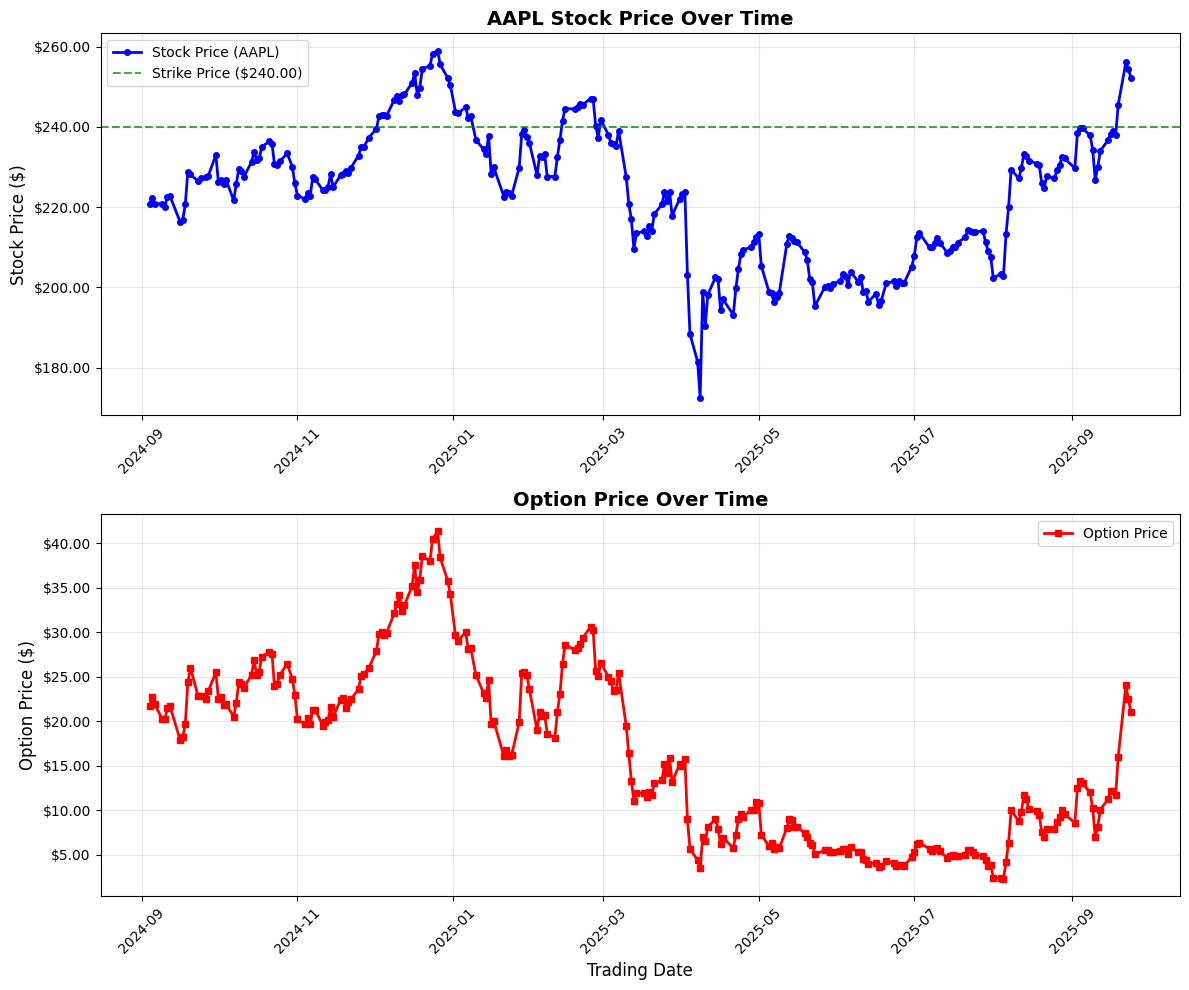

In [159]:
import matplotlib.pyplot as plt

# Create subplots with 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Subplot 1: Stock Price
ax1.plot(df_ttm_close_stock['Trading_Date'], df_ttm_close_stock['Stock_Price'], 
         color='blue', linewidth=2, label='Stock Price (AAPL)', marker='o', markersize=4)
ax1.axhline(y=strike_price, color='green', linestyle='--', alpha=0.7, label=f'Strike Price (${strike_price:.2f})')
ax1.set_title('AAPL Stock Price Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Stock Price ($)', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))

# Subplot 2: Option Price
ax2.plot(df_ttm_close_stock['Trading_Date'], df_ttm_close_stock['Option_Price'], 
         color='red', linewidth=2, label='Option Price', marker='s', markersize=4)
ax2.set_title('Option Price Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Trading Date', fontsize=12)
ax2.set_ylabel('Option Price ($)', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


## LSTM Model Construction

In [160]:
# CUDA Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Select features for Convolutional LSTM
# Convolutional features: [S_0, TTM, K, imp_vol_last]
conv_features = ['Stock_Price', 'TTM_Days', 'Strike_Price', 'imp_vol_last']
# LSTM features: Option_Price (time series)
lstm_features = ['Option_Price']
target_column = 'Option_Price'

# Extract features and target
conv_data = df_ttm_close_stock[conv_features].values
lstm_data = df_ttm_close_stock[lstm_features].values
target = df_ttm_close_stock[target_column].values

# Normalize features using MinMaxScaler
scaler_conv = MinMaxScaler()
scaler_lstm = MinMaxScaler()
scaler_target = MinMaxScaler()

# Fit and transform features
conv_data_normalized = scaler_conv.fit_transform(conv_data)
lstm_data_normalized = scaler_lstm.fit_transform(lstm_data)
target_normalized = scaler_target.fit_transform(target.reshape(-1, 1)).flatten()

In [161]:
# Create sequences for Convolutional LSTM
def create_conv_lstm_sequences(conv_data, lstm_data, target, sequence_length):
    """
    Create sequences for Convolutional LSTM model
    
    Args:
        conv_data: Convolutional features [S_0, TTM, K, imp_vol_last]
        lstm_data: LSTM features [Option_Price] 
        target: Normalized target values
        sequence_length: Number of days to use for prediction (N)
    
    Returns:
        X_conv: Convolutional input sequences of shape (samples, sequence_length, conv_features)
        X_lstm: LSTM input sequences of shape (samples, sequence_length, lstm_features)
        y: Target values of shape (samples,)
    """
    X_conv, X_lstm, y = [], [], []
    
    for i in range(sequence_length, len(conv_data)):
        # Take sequence_length days of convolutional features
        X_conv.append(conv_data[i-sequence_length:i])
        # Take sequence_length days of LSTM features (option prices)
        X_lstm.append(lstm_data[i-sequence_length:i])
        # Target is the next day's option price
        y.append(target[i])
    
    return np.array(X_conv), np.array(X_lstm), np.array(y)

In [162]:
# Model parameters
CONV_INPUT_SIZE = len(conv_features)
LSTM_INPUT_SIZE = len(lstm_features)
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1
DROPOUT = 0.02
SEQUENCE_LENGTH = 15 
# Training parameters
NUM_EPOCHS = 1000
BATCH_SIZE = 32

In [163]:
X_conv, X_lstm, y = create_conv_lstm_sequences(conv_data_normalized, lstm_data_normalized, target_normalized, SEQUENCE_LENGTH)
# Split data into train and test sets
# Use 90% for training, 10% for testing
train_size = int(0.9 * len(X_conv))
test_size = len(X_conv) - train_size

X_conv_train, X_conv_test = X_conv[:train_size], X_conv[train_size:]
X_lstm_train, X_lstm_test = X_lstm[:train_size], X_lstm[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors and move to device (CUDA/CPU)
X_conv_train_tensor = torch.FloatTensor(X_conv_train).to(device)
X_lstm_train_tensor = torch.FloatTensor(X_lstm_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_conv_test_tensor = torch.FloatTensor(X_conv_test).to(device)
X_lstm_test_tensor = torch.FloatTensor(X_lstm_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)


In [164]:
# Define Convolutional LSTM Model Architecture
class ConvLSTMOptionPrice(nn.Module):
    def __init__(self, conv_input_size, lstm_input_size, hidden_size, num_layers, output_size, dropout=0.2):
        """
        Convolutional LSTM model for option price prediction
        
        Args:
            conv_input_size: Number of convolutional features (4: S_0, TTM, K, imp_vol_last)
            lstm_input_size: Number of LSTM features (1: Option_Price)
            hidden_size: Number of LSTM hidden units
            num_layers: Number of LSTM layers
            output_size: Number of output units (1 for option price)
            dropout: Dropout rate for regularization
        """
        super(ConvLSTMOptionPrice, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Convolutional layers for spatial feature extraction
        self.conv1d_1 = nn.Conv1d(in_channels=conv_input_size, out_channels=32, kernel_size=3, padding=1)
        self.conv1d_2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv1d_3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        
        # LSTM layer for temporal modeling
        self.lstm = nn.LSTM(
            input_size=lstm_input_size + 32,  # LSTM features + conv features
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc3 = nn.Linear(hidden_size // 4, output_size)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x_conv, x_lstm):
        """
        Forward pass through the Convolutional LSTM model
        
        Args:
            x_conv: Convolutional input tensor of shape (batch_size, sequence_length, conv_input_size)
            x_lstm: LSTM input tensor of shape (batch_size, sequence_length, lstm_input_size)
        
        Returns:
            output: Predicted option price of shape (batch_size, output_size)
        """
        batch_size, seq_len, conv_features = x_conv.shape
        
        # Reshape for 1D convolution: (batch_size, conv_features, seq_len)
        x_conv_reshaped = x_conv.transpose(1, 2)
        
        # Apply convolutional layers
        conv_out = self.relu(self.bn1(self.conv1d_1(x_conv_reshaped)))
        conv_out = self.relu(self.bn2(self.conv1d_2(conv_out)))
        conv_out = self.relu(self.bn3(self.conv1d_3(conv_out)))
        
        # Reshape back: (batch_size, seq_len, conv_out_features)
        conv_out = conv_out.transpose(1, 2)
        
        # Combine convolutional features with LSTM features
        combined_features = torch.cat([x_lstm, conv_out], dim=2)
        
        # Initialize hidden state on the same device as input
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x_conv.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x_conv.device)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(combined_features, (h0, c0))
        
        # Take the last output from the sequence
        last_output = lstm_out[:, -1, :]
        
        # Apply dropout
        last_output = self.dropout(last_output)
        
        # Fully connected layers
        out = self.relu(self.fc1(last_output))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)
        
        return out

In [165]:
# Create model instance and move to device (CUDA/CPU)
model = ConvLSTMOptionPrice(
    conv_input_size=CONV_INPUT_SIZE,
    lstm_input_size=LSTM_INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=OUTPUT_SIZE,
    dropout=DROPOUT
).to(device)

# Training Setup
# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=10, 
)

# Create data loaders for Convolutional LSTM
train_dataset = TensorDataset(X_conv_train_tensor, X_lstm_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_conv_test_tensor, X_lstm_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Lists to store training history
train_losses = []
test_losses = []
learning_rates = []


In [166]:
# Training Loop
for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for batch_idx, (conv_data, lstm_data, target) in enumerate(train_loader):
        # Zero gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(conv_data, lstm_data)
        # Calculate loss
        loss = criterion(output.squeeze(), target)
        # Backward pass
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Update weights
        optimizer.step()
        train_loss += loss.item()
    
    # Calculate average training loss
    avg_train_loss = train_loss / len(train_loader)
    
    # Evaluation phase
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for conv_data, lstm_data, target in test_loader:
            output = model(conv_data, lstm_data)
            loss = criterion(output.squeeze(), target)
            test_loss += loss.item()
    
    # Calculate average test loss
    avg_test_loss = test_loss / len(test_loader)
    
    # Store losses
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Learning rate scheduling
    scheduler.step(avg_test_loss)
    
    # Early stopping condition
    if avg_test_loss < 0.0001:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]')
        print(f'Test Loss: {avg_test_loss:.6f}')
        break
    
    # Print progress
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]  Test Loss: {avg_test_loss:.6f}')




Epoch [50/1000]  Test Loss: 0.006795
Epoch [100/1000]  Test Loss: 0.006104
Epoch [150/1000]  Test Loss: 0.006268
Epoch [200/1000]  Test Loss: 0.006166
Epoch [250/1000]  Test Loss: 0.006233
Epoch [300/1000]  Test Loss: 0.006274
Epoch [350/1000]  Test Loss: 0.006269
Epoch [400/1000]  Test Loss: 0.006423
Epoch [450/1000]  Test Loss: 0.006171
Epoch [500/1000]  Test Loss: 0.006288
Epoch [550/1000]  Test Loss: 0.006170
Epoch [600/1000]  Test Loss: 0.006469
Epoch [650/1000]  Test Loss: 0.006373
Epoch [700/1000]  Test Loss: 0.006137
Epoch [750/1000]  Test Loss: 0.006316
Epoch [800/1000]  Test Loss: 0.006615
Epoch [850/1000]  Test Loss: 0.006381
Epoch [900/1000]  Test Loss: 0.006571
Epoch [950/1000]  Test Loss: 0.006291
Epoch [1000/1000]  Test Loss: 0.006347


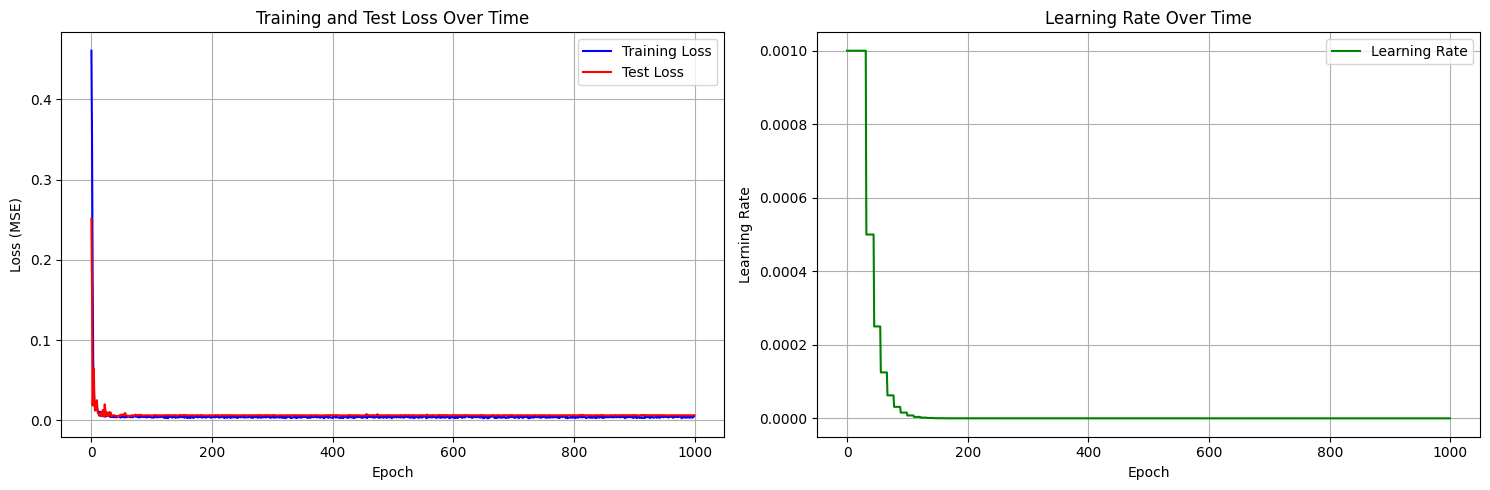

In [167]:
# Model Evaluation and Visualization
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.plot(test_losses, label='Test Loss', color='red')
ax1.set_title('Training and Test Loss Over Time')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True)

# Plot learning rate
ax2.plot(learning_rates, label='Learning Rate', color='green')
ax2.set_title('Learning Rate Over Time')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [175]:
# During evaluation (in your test loop or plotting code)
model.eval()
predictions_normalized = []
actual_deltas_normalized = []  # For reference, optional

with torch.no_grad():
    for i in range(len(X_conv_test_tensor)):
        conv_input = X_conv_test_tensor[i].unsqueeze(0)  # Add batch dim
        lstm_input = X_lstm_test_tensor[i].unsqueeze(0)
        predicted_delta = model(conv_input, lstm_input).squeeze().item()
        
        # Get last option price in the sequence (normalized)
        last_option_normalized = X_lstm_test_tensor[i, -1].item()  # Assuming LSTM_INPUT_SIZE=1
        
        # Compute predicted absolute value (still normalized)
        predicted_normalized = last_option_normalized + predicted_delta
        predictions_normalized.append(predicted_normalized)
        
        # Optional: Track actual delta for loss/debug
        actual_delta_normalized = y_test_tensor[i].item()
        actual_deltas_normalized.append(actual_delta_normalized)

# Inverse-scale predictions and actuals (assuming you have a scaler for target)
# Replace with your actual inverse transform logic
predictions_original = scaler_target.inverse_transform(np.array(predictions_normalized).reshape(-1, 1)).flatten()
actual_values_original = scaler_target.inverse_transform(y_test.reshape(-1, 1) + X_lstm_test[:, -1, 0].reshape(-1, 1)).flatten()  # Adjust actuals similarly
# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actual_values_original, predictions_original)
mse = mean_squared_error(actual_values_original, predictions_original)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values_original, predictions_original)

print(f"Mean Absolute Error (MAE): ${mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): $1.9745
R-squared (R²): 0.8641


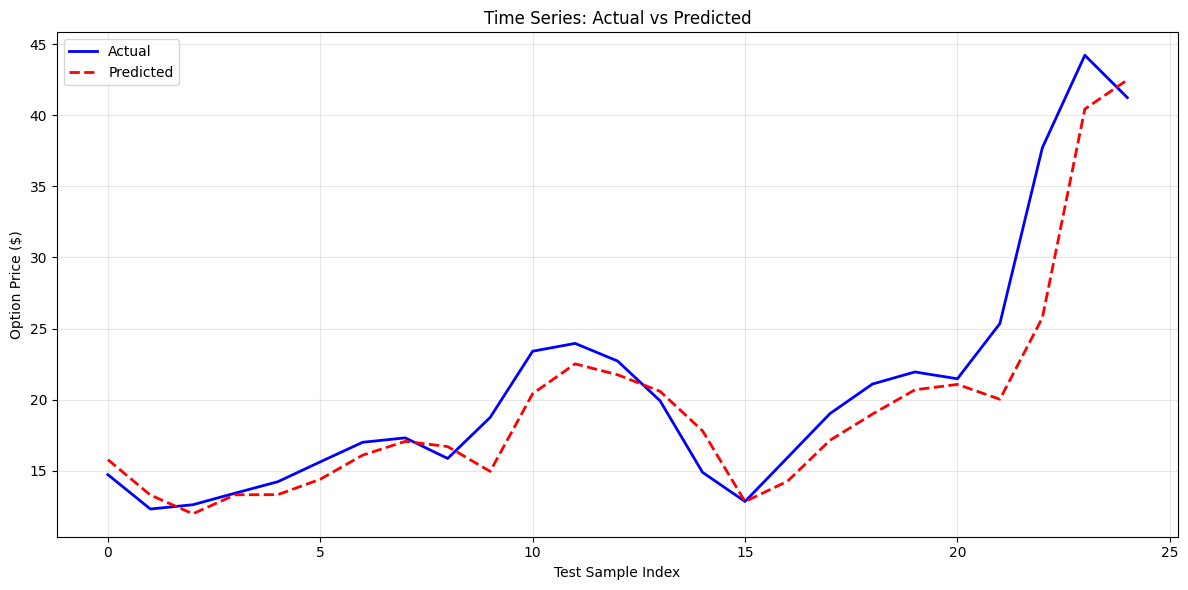

In [170]:
# Simplified Visualization - Time Series Only
plt.figure(figsize=(12, 6))

# Plot time series comparison
test_indices = range(len(actual_values_original))
plt.plot(test_indices, actual_values_original, 'b-', label='Actual', linewidth=2)
plt.plot(test_indices, predictions_original, 'r--', label='Predicted', linewidth=2)
plt.xlabel('Test Sample Index')
plt.ylabel('Option Price ($)')
plt.title('Time Series: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


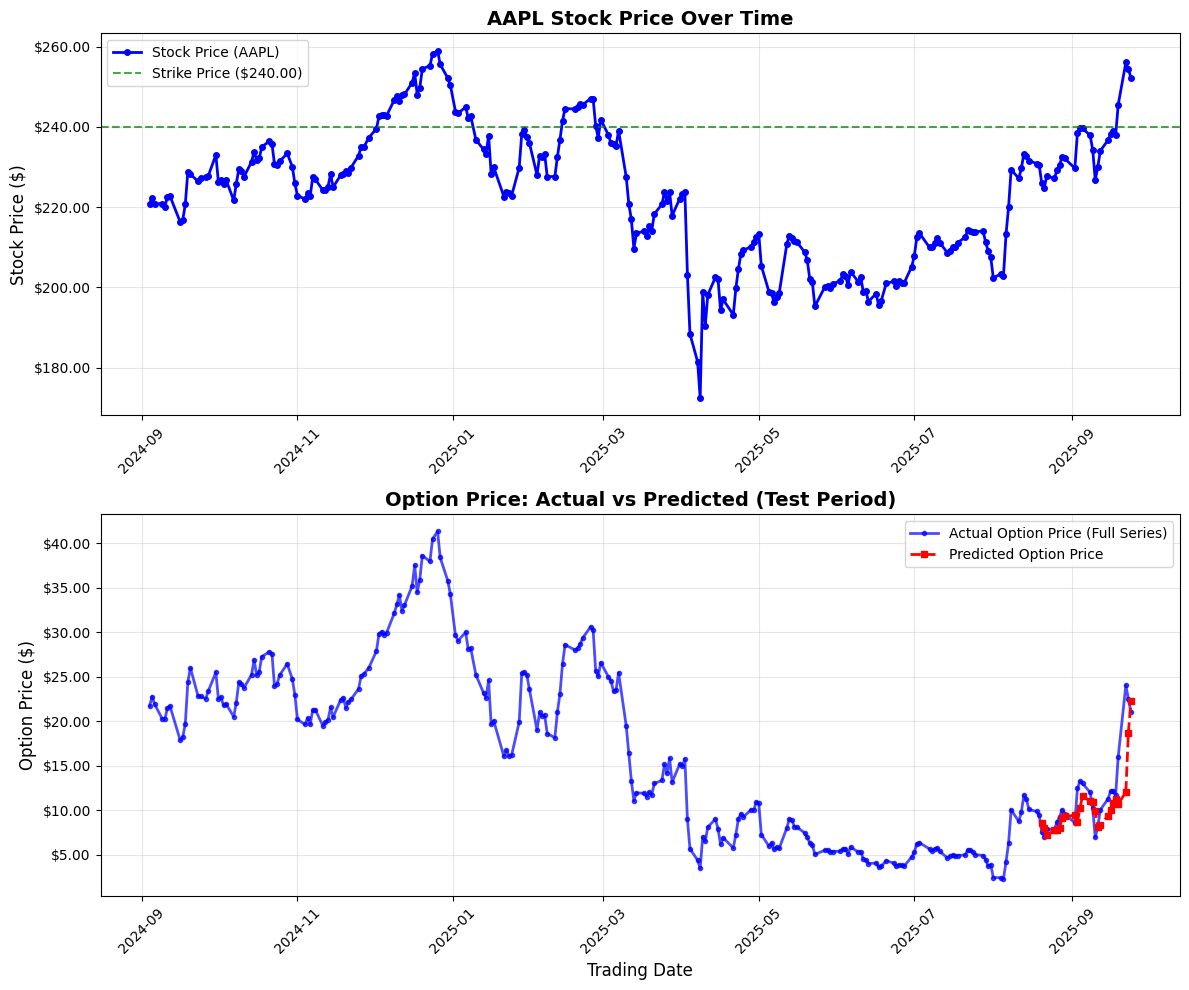


Data Validation:
Total dataframe length: 262
Sequence length: 15
Train size: 222
Test start index: 237
Number of test samples: 25
Test period dates: 2025-08-20 to 2025-09-24
Predictions range: $7.21 - $22.29
Actual test range: $6.96 - $24.03
Full series range: $2.29 - $41.35

Date Verification (first 3 test points):
Date: 2025-08-20, Predicted: $8.61, Actual: $7.55
Date: 2025-08-21, Predicted: $8.01, Actual: $7.03
Date: 2025-08-22, Predicted: $7.21, Actual: $7.85


In [174]:
# Corrected Combined Visualization with Proper Scaling
import matplotlib.pyplot as plt

# Create subplots with 2 rows and 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Subplot 1: Stock Price
ax1.plot(df_ttm_close_stock['Trading_Date'], df_ttm_close_stock['Stock_Price'], 
         color='blue', linewidth=2, label='Stock Price (AAPL)', marker='o', markersize=4)
ax1.axhline(y=strike_price, color='green', linestyle='--', alpha=0.7, label=f'Strike Price (${strike_price:.2f})')
ax1.set_title('AAPL Stock Price Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Stock Price ($)', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))

# Subplot 2: Option Price (Actual vs Predicted) - CORRECTED DATES
# The test data corresponds to the last portion of the dataframe after sequence creation
# Since we used 90% train/10% test split, test data starts from train_size + SEQUENCE_LENGTH
train_size = int(0.9 * (len(df_ttm_close_stock) - SEQUENCE_LENGTH))
test_start_idx = train_size + SEQUENCE_LENGTH
test_dates = df_ttm_close_stock['Trading_Date'].iloc[test_start_idx:test_start_idx + len(actual_values_original)].values

# Plot full actual option price series
ax2.plot(df_ttm_close_stock['Trading_Date'], df_ttm_close_stock['Option_Price'], 
         color='blue', linewidth=2, label='Actual Option Price (Full Series)', marker='o', markersize=3, alpha=0.7)

# Plot predicted values for test period only
ax2.plot(test_dates, predictions_original, 
         color='red', linewidth=2, label='Predicted Option Price', marker='s', markersize=4, linestyle='--')


ax2.set_title('Option Price: Actual vs Predicted (Test Period)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Trading Date', fontsize=12)
ax2.set_ylabel('Option Price ($)', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print data validation info
print(f"\nData Validation:")
print(f"Total dataframe length: {len(df_ttm_close_stock)}")
print(f"Sequence length: {SEQUENCE_LENGTH}")
print(f"Train size: {train_size}")
print(f"Test start index: {test_start_idx}")
print(f"Number of test samples: {len(actual_values_original)}")
print(f"Test period dates: {test_dates[0]} to {test_dates[-1]}")
print(f"Predictions range: ${predictions_original.min():.2f} - ${predictions_original.max():.2f}")
print(f"Actual test range: ${actual_values_original.min():.2f} - ${actual_values_original.max():.2f}")
print(f"Full series range: ${df_ttm_close_stock['Option_Price'].min():.2f} - ${df_ttm_close_stock['Option_Price'].max():.2f}")

# Verify the dates match by checking a few sample points
print(f"\nDate Verification (first 3 test points):")
for i in range(min(3, len(test_dates))):
    print(f"Date: {test_dates[i]}, Predicted: ${predictions_original[i]:.2f}, Actual: ${actual_values_original[i]:.2f}")
